In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

***
***
# Ch. 14 - Deep Computer Vision with Convolutional Neural Networks

## Main Conceptual Applications

### Implementing a Convolutional Layer in TensorFlow

**Key Notes:**

- Mini-batches, in the context of images, input data in the form of mini-batches are typically 4D tensors: $ \left[ \text{# in the mini-batch}, \text{width}, \text{height}, \text{channels} \right] $ 

- Weight of a convolutional layer are typically 4D tensors: $ \left[ f_h, f_w, f_n', f_n \right] $

- Bias terms are typically 1D tensors: $ \left[ f_n \right] $

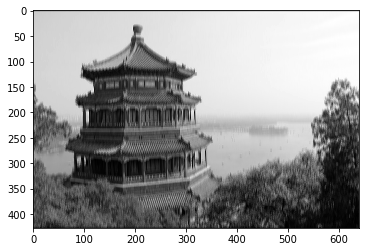

In [3]:
# CODE FROM THE BOOK:
from sklearn.datasets import load_sample_image
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# Load sample images & scale them (0 to 255 down to 0 to 1)
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255

images = np.array([china, flower])

batch_size, height, width, channels = images.shape

# Create two filters, both 7 x 7
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # 1st filter = vertical line
filters[3, :, :, 1] = 1 # 2nd filter = horizontal line

# Filter the images using zero padding and a stride of 1
# images - mini-batch 4D tensor [# in mini-batch, width, height, channels]
# filters - set of filters to apply to each image in the mini-batch
# strides - could be an int or a 1D array, len=4, look 4 documentation
# padding - SAME or VALID
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 0], cmap="gray")
plt.show()

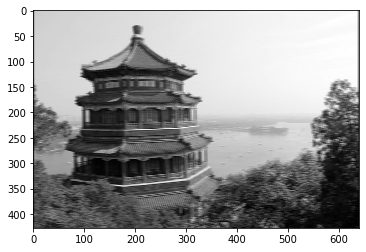

In [4]:
plt.imshow(outputs[0, :, :, 1], cmap="gray")
plt.show()

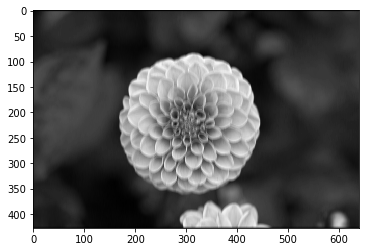

In [5]:
plt.imshow(outputs[1, :, :, 0], cmap="gray")
plt.show()

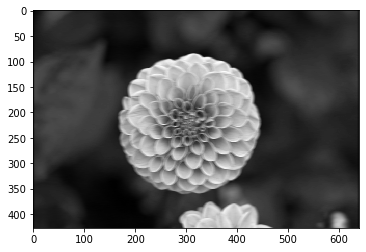

In [6]:
plt.imshow(outputs[1, :, :, 1], cmap="gray")
plt.show()

In [7]:
# Defining the number of filters/layers as trainable parameters
# Can use cross-validation to find correct hyperparameters, but takes
# a lot of time
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="same", activation="relu")

### Computational Requirements (Trainable Params, Number of Multiplicative Operations, and RAM) Calculation given CNN Architecture

Example: Given...
- A convolutional layer
 - 5x5 filters
 - 200 feature maps
 - Size 150x100 RGB image
 - Stride 1
 - "SAME" padding, so input of 150x100 -> output of 150x100
 
Computational Reqs:
- Trainable Params:
 - $(5\times5\times3 + 1) \times 200 = 15,200$ trainable parameters (weights on each filter in the 200 feature maps) for the total convolutional layer

- Number of Multiplications:
 - $5 \times 5 \times \times 3 = 75 \frac{\text{multiplications}}{\text{neuron}}$
 - $ 150 \times 100 \times 200 = 3,000,000 \text{neurons}$
 - $75 \frac{\text{multiplications}}{\text{neuron}} \times 3,000,000 \text{neurons} = 225,000,000 \text{multiplications}$
 
- Memory to hold all forward-prop multiplications:
 - $ \text{feature maps} \times \text{width} \times \text{height} \times \text{number of channels} \times \text{bit size} = \text{Memory Req for Conv Layer}$
 - Example: $ 200 \times 150 \times 100 \times 32 = 96,000,000 bits \times \frac{1 \text{byte}}{8 \text{bits}} = 12 MB$ per instance.
 
Solutions to RAM Overloading:
- Reduce mini-batch size
- Switch from 32-bit floats to 16-bit floats
- Distribute layers of the CNN across multiple devices

### Implementing a Max Pooling Layer in TensorFlow

**Key Notes**:
- In Keras, default stride is set to the pooling size.
- Max pooling is more popular than average nowadays...
 - Reduces computational complexity
 - Only the strongest features propagate through

In [14]:
max_pool = keras.layers.MaxPool2D(pool_size=2)
avg_pool = keras.layers.AvgPool2D(pool_size=2)

- Depthwise max pooling:
 - Equivalent to max pooling, but across different channels (Ex. RGB or the number of filters in a convolutional layer).
 - Performed via the _tf.nn.max_pool()_ function wrapped in a Keras _Lambda_ layer or in your own custom layer.
 - kernal depth, _ksize_ set to (1, 1, 1, kdepth) to map the kernal size of the batch, length, and width to 1 (map input of a batch, image length and width to each corresponding output pixel), and then the kdepth to however many stacked channels or filters one wishes to pool together.
 - stride depth, _strides_ set to (1, 1, 1, sdepth) to map the stride between batches, length, and width to 1 and then the sdepth to account for how many images to shift the depth kernal/filter down.
 - stride in depth must be a divisor of the input depth (Ex. if there's 15 filters, an sdepth of 3 or 5 would work, but 4 would not work).

In [15]:
output = tf.nn.max_pool(images,
                        ksize=(1, 1, 1, 3),
                        strides=(1, 1, 1, 3),
                        padding="VALID")

UnimplementedError: Depthwise max pooling is currently only implemented for CPU devices. [Op:MaxPool]

In [16]:
depth_pool = keras.layers.Lambda(
    lambda X: tf.nn.max_pool(X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                             padding="valid"))

- Global average pooling layer:
 - Useful as the last layer

In [17]:
global_avg_pool = keras.layers.GlobalAvgPool2D()

In [18]:
global_avg_pool_2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))

### Implementing CNN Architectures - Simple CNN

***
## Self-Quiz Questions

### Convolutional Layers

1. How does the architecture of the visual cortex relate to deep CNNs?

> CNNs were inspired by the idea that a local region of the visual field will only activate a certain set of neurons. Within the entire set of neurons that are activated from that small subsample of the visual field, only certain ones are activated in response to particular stimuli (examples being horizontal and vertical lines). Moreover, those "lower level" neurons are interconnected to other "higher level" neurons that will only activate in the presence of a more complex pattern (examples being a right hand corner). This sort of abstraction continues for layer after layer until a group of neurons will fire that indicate a particular object is in the field of view with a varying degree of confidence. CNNs were inspired from this finding (in the 1950s that measured the local receptive field's connection to particular neurons across different patterns of stimuli). As such, they employ layers that act as filters emphasizing the activation of artificial neurons in the presence of a particular pattern within a small subset of an input space. 

2. Why would you use zero padding before a convolutional layer?

> Zero padding is used to maintain a constant dimensionality from input to output when passing through a convolutional layer.

3. What is the advantage of adding stride to a convolutional layer? What happens to the size of the output given a particular sized input image as stride goes up.

> The advantage is that it reduces the amount of computations, and thus the computational complexity, in the convolutional layer by reducing the overlap on the input data of the convolution window. The result is the output dimensionality decreases along a particular dimension with an increase in stride in said dimension.

4. Given $i$ and $j$ in the output of a convolutional layer, $f_h$ and $f_w$ as the window dimensions, and $s_h$ and $s_w$ as the degree of stride along the height and width of an image, what input pixels are taken into account from the input image to $i$ and $j$ of the output image?

> Rows: $is_h$ to $is_h + f_h - 1$. Cols: $js_w$ + $js_w + f_w - 1$. 

5. Can you explain why you would want to stack multiple feature maps on top of one another? What is the big advantage of using and training the same filter across an entire image/instance of data?

> The main advantage is that multiple feature maps in a layer will train to recognize different patterns. However, since each feature map is training to recognize one thing at a time, it doesn't matter where that pattern is on its input. Once the specific feature map is trained to recognize a specific pattern, it will recognize it across any portion of the input data, not just in the localized region of that particular instance. As such, with one neuron per pixel in each feature map of a particular convolutional layer will map to a local receptive field of the layer before it, which, if it contains another dimension such as a RGB image's third dimension or another convolutional layer's set of feature maps, will be connected to each of those dimensions in turn.

6. What does the following equation describe? Can you name what each term represents?

$$ z_{i,j,k} = b_k + \sum_{u=0}^{f_h - 1} \sum_{v=0}^{f_w - 1} \sum_{k'=0}^{f_{n}' - 1} x_{i', j', k'} \cdot w_{u, v, k', k}  \text{   with} \left\{\begin{array}{lr}
        i' = i \times s_h + u\\
        j' = j \times s_w + v
        \end{array}\right\} $$

> \- Primes indicate the layer prior to the one being described. <br> - $z_{i,j,k}$: The pixel in the ith row, jth column of feature map k in a given convolutional layer. <br> - $b_k$: Bias term for the filter used all over the given feature map k. <br> - $f_h$: Height of filter/receptive field in feature map k. <br> - $f_w$: Width of filter/receptive field in feature map k. <br> - $f_{n}'$: Number of feature maps, or depth across which convolution is being made, of previous layer (An example would be 3 for RGB images). <br> - $s_h$: stride in height of the filter/receptive field. <br> - $s_w$: stride in width of the filter/receptive field. <br> - $ x_{i', j', k'} $: The index of the input to this particular layer. In the context of images, this would start at the $i \times s_h + 0$th row, $j \times s_w$th column, sum across the filter height and width, and then across all the stacks of the layer before (across each of RGB, across all of the feature maps in the previous layer, etc.) <br> - $w_{u, v, k', k}$: The connection weights between the $u$th row and $v$th column of the $k$th feature map in the current layer and the $k'$th feature map or input space of the previous layer.

7. What is the dimensionality of a typical mini-batch of input data into a CNN? What about the structure of the weights of a convolutional layer? The structure of the biases?

> See "Implementing a Convolutional Layer in TensorFlow".

8. Why do CNNs take up so much RAM? What can you do if the training process crashes?

> Backprop adjustments require all intermediate values during a forward pass.


### Pooling Layers

1. What are some of the main goals of a pooling layer?

> To reduce the computational load of the network by taking an input, mapping a small portion of that input to an output (just like a convolutional layer) and aggregating that information into a signle output value with the goal of modifying it as little as possible. The idea is that the size of the data is reduced but the main structure of the information remains the same.

> Provides invariance of the network to small translations. Shifts of a few pixels, which would drastically change a fully-connected DNN, are all mapped to the same values in certain cases. So, similar images should produce similar responses from the network making it more robust.

2. What are some different types of pooling layers?

> Max Pooling Layer: From the subset of the input to the pooling layer, for each channel independently mapped to their out subsequent output channels (typically), take the largest value of each subset and map it to the subsequent output value. For example, if there were a 2x2 rectangle representing the subset filter that contained the input subset at $i$, $j$ -> $[1, 2; 5, 3]$, the value $5$ would represent the output from that subset.

> Average Pooling Layer: Similar to a Max Pooling Layer but taking the average of the inputs as the subsequent output mapping.

> Global Average Pooling Layer: Takes the mean of the entire image and maps it to a single output.

3. If a max pooling layer had a 2x2 filter and a stride of 2, what is the size of the output compared to the input? What about if it had a stride of 1?

> For a 2x2 filter and a stride of 2 in a max pooling layer, the output would be 1/2 the size of the input. For a stride of 1, the output would be the same size as the input and thus would defeat the purpose of the pooling layer (given a quick look at the equation for a convolutional layer, replacing the weights and biases with a max funciton).

4. What are the downsides to pooling layers?

> Can be highly destructive. Dropping half of the rows and half the columns reduces the amount of information passing through to the next layer by 75%, which can lead to missing patterns.

> The invariance offered by pooling layers is sometimes not desired, such as when trying to perform semantic segmentation, where if the target image shifts by a small value, the corresponding output should shift by a small value.

### CNN Architectures

1. What was one of the first CNN architectures? What was a big drawback in its output layer and why?



2. What aspects of the design made AlexNet so special? 

3. What does the following equation describe? What does it do and what does it encourage?

$$ b_i = ... $$

4. What were some unique features of GoogLeNet?

5. Are there any drawbacks to inception layers?

6. Explain the advantages to a 1x1 convolutional kernal and what they do.

7. What is the defining feature of the ResNet architecture? Why did it improve classification performance?

8. What are some of the advantages to separable convolutional layers? Are there any disadvantages?

9. What are the three layers to an SEblock? What is its function?

### Implementing ResNet-34 CNN in Keras

1. What are the functions that you need to define in the ResidualUnit layers when implementing the ResNet-34 architecture in Keras?

2. Can you draw the ResidualUnit architecture from memory?

### Pretrained Models for Transfer Learning

1. If the aspect ratio of an image won't be preserved in resizing it, what can you do to make sure the dimensions aren't distorted?

2. What are some of the advantages to creating a tf.data preprocessing pipeline for your network?

3. Describe the process and some of the functions needed in Keras to use pretrained layers.


### Classification and Localization

1. What are the four things you need to predict to localize an object in an image?

2. What are some good tools to annotate images?

3. What's a good practice to perform on the values of the bounding boxes before feeding it into the network? 

4. What's a good practice when predicting bounding boxes?

5. What is the most common loss function to evaluate how well the model predicts bounding boxes?


### Object Detection

1. How can you convert a dense layer to a convolutional layer? What are some advantages to replacing dense layers with convolutional layers? 

2. Whats the difference between a CNN and a FCN?

3. Why are FCNs so efficient? 

4. What is You Only Look Once (YOLO)? What are the main improvements it provides?

5. Summarize the Mean Average Precision (MAP) metric and how the precision v. accuracy tradeoff applies to it.

### Semantic Segmentation

1. What is an upsampling layer and why is it used in semantic segmentation?

2. How does the stride effect a transposed convolutional layer? Why does it affect it this way?

3. How is the precision of semantic segmentation improved?

***

***
## Book-Quiz Questions

1. What are the advantages of a CNN over a fully connected DNN for image classification?

> A fully connected DNN results in a pattern whose continued repetition undergoes a combinatorial explosion of new constituent elements given an increasing input space. For example, with a DNN, if an input layer starts off with a 200 x 200 pixel black and white input space, that's 40,000 inputs when flattened. If the next layer has 10,000 neurons, that becomes a weight matrix that contains $ [40,000, 10,000] $ or 400,000,000 weights to train with just one layer. CNNs on the other hand employ not _fully connected layers_ but _partially connected convolutional layers_, which limit the growth of the weights that must be trained while still allowing for higher order patterns to be assembled/recognized when inputs are propagated through the network.

2. Consider a CNN composed of three convolutional layers, each with 3 × 3 kernels, a stride of 2, and "same" padding. The lowest layer outputs 100 feature maps, the middle one outputs 200, and the top one outputs 400. The input images are RGB images of 200 × 300 pixels. What is the total number of parameters in the CNN? If we are using 32-bit floats, at least how much RAM will this network require when making a prediction for a single instance? What about when training on a mini-batch of 50 images?

> Total Number of Parameters:

> RAM Requirements for a Single Instance:

> RAM Requirements for a Mini-Batch: 

3. If your GPU runs out of memory while training a CNN, what are five things you could try to solve the problem?

> 1. 
> 2. 
> 3. 
> 4. 
> 5. 

4. Why would you want to add a max pooling layer rather than a convolutional layer with the same stride?

> Max pooling layers do not have weights, trainable or no. As such, they can reduce the input dimensionality to the next layer in the network and add robustness to invariance without adding additional trainable parameters.

5. When would you want to add a local response normalization layer?

6. Can you name the main innovations in AlexNet, compared to LeNet-5? What about the main innovations in GoogLeNet, ResNet, SENet, and Xception?

7. What is a fully convolutional network? How can you convert a dense layer into a convolutional layer?

8. What is the main technical difficulty of semantic segmentation?

***

***
## Book Exercise Questions

9. Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST.


10. Use transfer learning for large image classification, going through the following steps. Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow Datasets). Split it into a training set, a validation set, and a test set. Build the input pipeline, including the appropriate preprocessing operations, and optionally add data augmentation.Fine-tune a pretrained model on this dataset.

11. Go through TensorFlow’s Style Transfer tutorial seen [here](https://www.tensorflow.org/tutorials/generative/style_transfer). It is a fun way to generate art using Deep Learning.


***

***
## Flashcards of Important Topics

- **Convolutional Neural Network (CNN)**: 

- **Local Receptive Field**: The idea that only a small portion of a visual field/image will excite a set of biological or artificial neurons, thus indicating that said neurons are specialized and tied to that localized region. For example, if there are multiple temperature sensors all over the room, and the fridge's compressor kicks on, the temperature sensor is eventually activated. The signals it sends to the thermostat are carrying current, which indicates they are excited. The temperature sensor in that region would be akin to the local receptive field. 

- Convolutional Layer: A layer of a neural network which employs the principal of convolution, $ f(x) * g(x) = \int_{-\infty}^{+\infty}{f(\lambda)g(x - \lambda) d\lambda} $, which qualitatively is a metric of... "what is the sum of the area under the window of a particular function when that window is slid along the entirity of that dimension where each point of the resulting output is the area under the first function within the bounds of that window scaled by the height of said window, which is the second function, at all the different points of the window." As such, in the context of a 2D image, a convolutional layer is a layer that maps a small subspace of the previous layer (say, from row $i$ to row $i+(f_h -1)$ and column $j$ to $j+(f_w -1)$ where $f_h$ and $f_w$ are the window height and width respectively ) onto a smaller section of the next layer by summing and weighting each pixel in that space (where $i$ and $j$ are varied to cover the entire input space).

- Zero Padding: In the context of an image in a CNN, it is the process of adding zeros to the outer edge of an image such that the resultant output of a convolutional layer remains dimensionally the same as its input.

- Stride: The degree to which a convolutional window will shift from one window to the next along a given dimension.
 
- Filter/Convolutional Kernal: The weights of the convolutional window that are multiplied to its corresponding subset of the input whose products are subsequently summed to provide the value of a particular output pixel/region.

- Feature Map: A convolutional layer that uses the same filter/convolutional kernal or weights over the entire input region.
 
- Pooling Layer: Similar to a convolutional layer, a subset of the input to the layer is mapped to a single output value, without modifying it by any trainable weights or a bias term, such that the size of the input layer is reduced when mapped to the output while still retaining as much of the information as possible.

- Subsample: Reduce the amount of data between the input and the output while retaining as much of the information structure as possible.

- Data Augmentation:

- Local Response Normalization: 

- Inception Modules: 

- Depth Concatenation Layer: 

- Bottleneck Layers: 

- Shortcut Connection:

- Residual Learning:

- Depthwise Separable Convolutional Layer/Separable Convolutional Layer:

- SEblock: 

- IntersectionOverUnion: 

- Fully Convolutional Network (FCN): 

- Anchor Boxes: 

- You Only Look Once (YOLO):  

- Mean Average Precision (MAP): 

- Upsampling Layer: 

- Transposed Convolutional Layer: 

***

***
## Sectional Summaries

### Convolutional Layers

### Pooling Layers

### CNN Architectures

### Implementing ResNet-34 in Keras

### Pretrained Models for Transfer Learning

### Classification and Localization

### Object Detection

### Semantic Segmentation

***

***
## Memory Palace

### Memory Palace Keys

#### Kitchen

- 1 = Fridge

- 2 = Microwave

- 3 = Cabinet above wine bottles

- 4 = Oven

- 5 = Dishwasher

- 6 = Island Cabinet below plant

#### Living Room

- 1 = Mini-Fridge

- 2 = Coffee Table/Trunk

- 3 = Entertainment Center, Center Cabinet

- 4 = Windowsill

#### Bathroom

- 1 = Cabinet below the sink

- 2 = Towel Closet

- 3 = Sink

- 4 = Toilet

- 5 = Shower

#### Bedroom

- 1 = Desk

- 2 = Bookshelf

- 3 = Closet

- 4 = Tall Dresser

- 5 = Nightstand

- 6 = Vanity

- 7 = Bed's Center Hidden Compartment

### Chapter Sections

#### Convolutional Layers

#### Pooling Layers

#### CNN Architectures

#### Implementing ResNet-34 in Keras

#### Pretrained Models for Transfer Learning

#### Classification and Localization

#### Object Detection

#### Semantic Segmentation

***

***
## Spaced Repetition

12/31/2019: Skimmed through once. Then went through and finished creating self-test questions and flashcards from identifying important topics. Lastly, read the first and last paragraph of each section for the exposure.

1/1/2019: Slight review of all the terms and questions I wrote down along with the book's quiz questions. Deep dive from the start of the chapter up to the "Stacking Multiple Feature Maps" section of "Convolutional Layers". The goal for next time will be to get through its implementation and memory requirements section.

1/4/2019: Went through the implementation example and the computational requirements calculations. Fixed the PIL dependency issue and errors that were appearing in the 

